In [47]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def prepare_dataset(source_dir, dest_dir, test_size=300):
    classes = ['best', 'good', 'normal']
    
    for split in ['train', 'val', 'test']:
        for cls in classes:
            os.makedirs(os.path.join(dest_dir, split, cls), exist_ok=True)
    
    all_images = []
    for root, _, files in os.walk(source_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                all_images.append(os.path.join(root, file))
    
    # test 세트를 먼저 분리
    train_val_images, test_images = train_test_split(all_images, test_size=test_size, random_state=2024)
    
    # 남은 이미지를 train과 val로 분리 (80:20 비율)
    train_images, val_images = train_test_split(train_val_images, test_size=0.2, random_state=2024)
    
    for images, split in zip([train_images, val_images, test_images], ['train', 'val', 'test']):
        print(f"Processing {split} set:")
        for img_path in tqdm(images, desc=f"{split.capitalize()} set", unit="image"):
            if 'Apple_L' in img_path:
                cls = 'best'
            elif 'Apple_M' in img_path:
                cls = 'good'
            elif 'Apple_S' in img_path:
                cls = 'normal'
            else:
                continue
            
            dest_path = os.path.join(dest_dir, split, cls, os.path.basename(img_path))
            shutil.copy(img_path, dest_path)
    
    print("Dataset preparation completed.")
    print(f"Train images: {len(train_images)}")
    print(f"Validation images: {len(val_images)}")
    print(f"Test images: {len(test_images)}")

# 사용 예:
# prepare_dataset('./data/ref/', './data/apple_quality', test_size=300)

In [48]:
def create_yaml_file(dataset_path, yaml_path):
    yaml_content = f"""
path: {dataset_path}
train: train
val: val
test: test

nc: 3
names: ['best', 'good', 'normal']
    """

    yaml = os.path.join(yaml_path, 'apple_quality.yaml')
    with open(yaml, 'w') as f:
        f.write(yaml_content)
    
    print(f"YAML file created at {yaml_path}")

# 사용 예:
# create_yaml_file('./data/apple_quality', './data/apple_quality.yaml')

In [49]:
from ultralytics import YOLO
import os

def train_model(pretrained_weights, yaml_path='./data/', epochs=100, imgsz=224, batch=128, patience=20, project='runs/train', name='apple_quality_classifier'):
    model = YOLO(pretrained_weights)
    
    results = model.train(
        data=yaml_path,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        name=name,
        project=project,  # 프로젝트 디렉토리 지정
        patience=patience,
        save=True,
        save_period=10,
        device='0',
        plots=True,
        augment=True,
        mixup=0.1,
        mosaic=0.5,
        dropout=0.15,
        weight_decay=0.0005,
        warmup_epochs=3,
        cos_lr=True,
        lr0=0.01,
        lrf=0.01,
        label_smoothing=0.1,
        optimizer='AdamW',
        momentum=0.9,
        workers=8
    )
    
    print("Training completed.")
    
    # 최종 모델 저장
    final_model_path = os.path.join(project, name, 'weights', 'best.pt')
    model.save(final_model_path)
    print(f"Final model saved to {final_model_path}")
    
    return model, results

# 사용 예:
# trained_model, results = train_model('yolov8n-cls.pt', yaml_path='./data/apple_quality.yaml', epochs=100, imgsz=224, batch=128, patience=20)

In [52]:
import os
from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model_path, test_data_path):
    # 모델 로드
    model = YOLO(model_path)
    
    # 실제 레이블과 예측 레이블 저장을 위한 리스트
    true_labels = []
    pred_labels = []
    
    # 각 클래스 디렉토리에 대해 예측 수행
    for class_name in os.listdir(test_data_path):
        class_path = os.path.join(test_data_path, class_name)
        if os.path.isdir(class_path):
            results = model(class_path, imgsz=224, batch=32)
            
            for r in results:
                true_labels.append(class_name)
                # 변경된 부분: top1 인덱스를 사용하여 예측 클래스 가져오기
                pred_labels.append(r.names[r.probs.top1])
    
    # 클래스 이름 추출
    class_names = sorted(set(true_labels))
    
    # 분류 보고서 생성
    report = classification_report(true_labels, pred_labels, target_names=class_names)
    
    # 혼동 행렬 생성
    cm = confusion_matrix(true_labels, pred_labels, labels=class_names)
    
    # 정확도 계산
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    
    # 결과 출력
    print("Classification Report:")
    print(report)
    print(f"Overall Accuracy: {accuracy:.4f}")
    
    # 혼동 행렬 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return report, cm, accuracy


image 1/80 /mnt/c/soo/KDT/project/3_project/Gruit/ai/Yolo_classification/data/apple_quality/test/best/apple_fuji_L_1-11_1TOP.png: 224x224 best 1.00, normal 0.00, good 0.00, 0.2ms
image 2/80 /mnt/c/soo/KDT/project/3_project/Gruit/ai/Yolo_classification/data/apple_quality/test/best/apple_fuji_L_1-8_3FR90.png: 224x224 best 1.00, normal 0.00, good 0.00, 0.2ms
image 3/80 /mnt/c/soo/KDT/project/3_project/Gruit/ai/Yolo_classification/data/apple_quality/test/best/apple_fuji_L_10-18_3FR90.png: 224x224 best 1.00, good 0.00, normal 0.00, 0.2ms
image 4/80 /mnt/c/soo/KDT/project/3_project/Gruit/ai/Yolo_classification/data/apple_quality/test/best/apple_fuji_L_13-26_1TOP.png: 224x224 best 1.00, good 0.00, normal 0.00, 0.2ms
image 5/80 /mnt/c/soo/KDT/project/3_project/Gruit/ai/Yolo_classification/data/apple_quality/test/best/apple_fuji_L_13-34_4DI45.png: 224x224 best 1.00, good 0.00, normal 0.00, 0.2ms
image 6/80 /mnt/c/soo/KDT/project/3_project/Gruit/ai/Yolo_classification/data/apple_quality/test/be

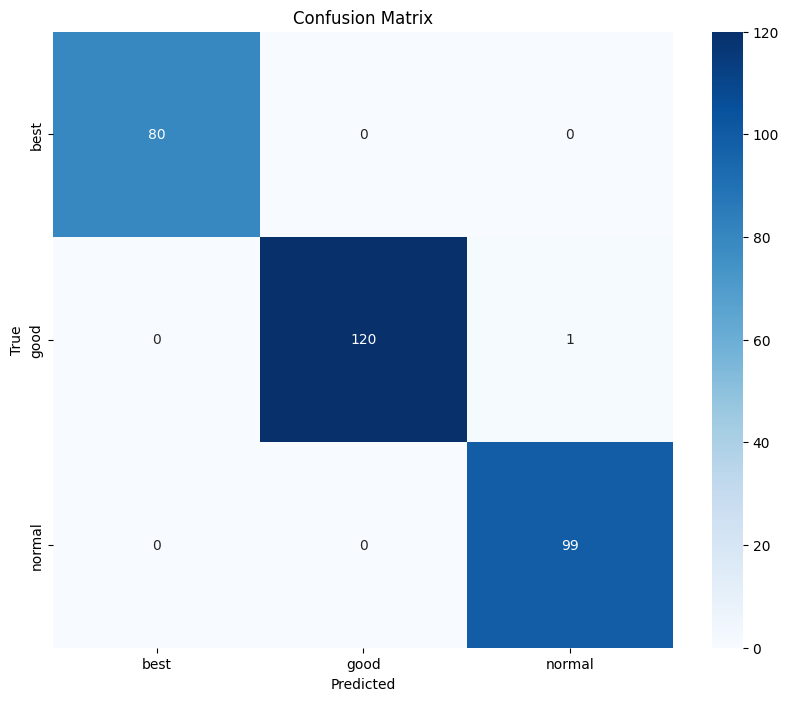

최종 정확도: 0.9967
All processes completed successfully.


In [63]:
def main():
    # 1. 데이터 준비
    source_dir = './data/ref/'
    dest_dir = './data/apple_quality/'
    # prepare_dataset(source_dir, dest_dir)

    # 2. YAML 파일 생성
    yaml_path = './data/apple_quality/'
    # create_yaml_file(dest_dir, yaml_path)

    # 3. 모델 학습
    pretrained_weights = 'yolov8m-cls.pt'
    yaml_path = './data/apple_quality'
    # model, results = train_model(pretrained_weights, yaml_path, epochs=100, imgsz=224, batch=64, patience=20)

    # 4. 모델 평가
    project = 'runs/train'  # 프로젝트 디렉토리
    name = 'apple_quality_classifier'  # 실험 이름
    
    best_model_path = os.path.join(project, name, 'weights', 'best.pt')
    test_data_path = os.path.join(dest_dir, 'test')
    
    # 모델 파일 존재 확인
    if not os.path.exists(best_model_path):
        print(f"모델 파일을 찾을 수 없습니다: {best_model_path}")
    else:
        report, confusion_mat, accuracy = evaluate_model(best_model_path, test_data_path)
        print(f"최종 정확도: {accuracy:.4f}")
    
        print("All processes completed successfully.")

if __name__ == "__main__":
    main()

테스트 데이터 경로: ./data/apple_quality/test
테스트 데이터 디렉토리 내용: ['best', 'good', 'normal']

image 1/80 /mnt/c/soo/KDT/project/3_project/Gruit/ai/Yolo_classification/data/apple_quality/test/best/apple_fuji_L_1-11_1TOP.png: 224x224 best 1.00, normal 0.00, good 0.00, 0.3ms
image 2/80 /mnt/c/soo/KDT/project/3_project/Gruit/ai/Yolo_classification/data/apple_quality/test/best/apple_fuji_L_1-8_3FR90.png: 224x224 best 1.00, normal 0.00, good 0.00, 0.3ms
image 3/80 /mnt/c/soo/KDT/project/3_project/Gruit/ai/Yolo_classification/data/apple_quality/test/best/apple_fuji_L_10-18_3FR90.png: 224x224 best 1.00, good 0.00, normal 0.00, 0.3ms
image 4/80 /mnt/c/soo/KDT/project/3_project/Gruit/ai/Yolo_classification/data/apple_quality/test/best/apple_fuji_L_13-26_1TOP.png: 224x224 best 1.00, good 0.00, normal 0.00, 0.3ms
image 5/80 /mnt/c/soo/KDT/project/3_project/Gruit/ai/Yolo_classification/data/apple_quality/test/best/apple_fuji_L_13-34_4DI45.png: 224x224 best 1.00, good 0.00, normal 0.00, 0.3ms
image 6/80 /mnt/c

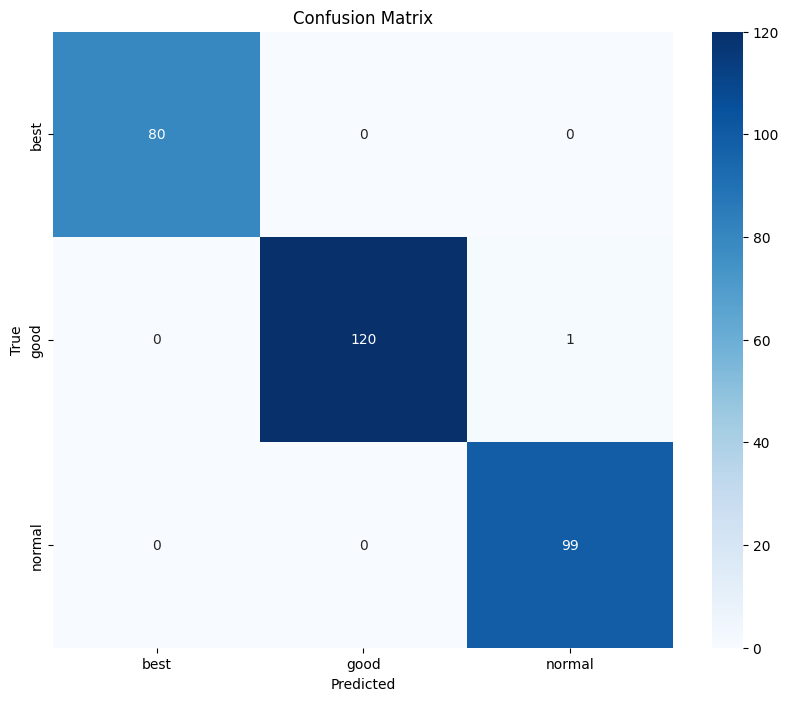

최종 정확도: 0.9967
All processes completed successfully.


In [59]:
from ultralytics import YOLO
import os
from PIL import Image
import numpy as np

def classify_apple(model_path, image_path):
    # 모델 로드
    model = YOLO(model_path)

    # 이미지 분류
    results = model(image_path)

    # 결과 처리
    for r in results:
        class_name = r.names[r.probs.top1]
        confidence = r.probs.top1conf.item()
        return class_name, confidence

def process_images(model_path, input_path):
    if os.path.isfile(input_path):
        # 단일 이미지 처리
        class_name, confidence = classify_apple(model_path, input_path)
        print(f"이미지: {input_path}")
        print(f"분류 결과: {class_name}, 신뢰도: {confidence:.2f}")
    elif os.path.isdir(input_path):
        # 디렉토리 내 모든 이미지 처리
        for filename in os.listdir(input_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                image_path = os.path.join(input_path, filename)
                class_name, confidence = classify_apple(model_path, image_path)
                print(f"이미지: {filename}")
                print(f"분류 결과: {class_name}, 신뢰도: {confidence:.2f}")
                print("---")
    else:
        print("유효한 이미지 파일 또는 디렉토리가 아닙니다.")

# 사용 예시
model_path = 'runs/train/apple_quality_classifier/weights/best.pt'  # 학습된 모델 경로
input_path = './target_image/'  # 테스트할 이미지 또는 디렉토리 경로
# input_path = './target_image/test'  # 테스트할 이미지 또는 디렉토리 경로

process_images(model_path, input_path)


image 1/1 /mnt/c/soo/KDT/project/3_project/Gruit/ai/Yolo_classification/target_image/4ce7aa2a-364c-4d9a-9fae-4b67ad93f26a.jpg: 224x224 normal 1.00, best 0.00, good 0.00, 13.1ms
Speed: 51.1ms preprocess, 13.1ms inference, 0.2ms postprocess per image at shape (1, 3, 224, 224)
이미지: 4ce7aa2a-364c-4d9a-9fae-4b67ad93f26a.jpg
분류 결과: normal, 신뢰도: 1.00
---

image 1/1 /mnt/c/soo/KDT/project/3_project/Gruit/ai/Yolo_classification/target_image/apple_fuji_L_1-13_3FR90.png: 224x224 best 1.00, good 0.00, normal 0.00, 7.7ms
Speed: 8.2ms preprocess, 7.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
이미지: apple_fuji_L_1-13_3FR90.png
분류 결과: best, 신뢰도: 1.00
---

image 1/1 /mnt/c/soo/KDT/project/3_project/Gruit/ai/Yolo_classification/target_image/apple_fuji_M_1-12_2FR45.png: 224x224 good 1.00, normal 0.00, best 0.00, 7.3ms
Speed: 11.1ms preprocess, 7.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
이미지: apple_fuji_M_1-12_2FR45.png
분류 결과: good, 신뢰도: 1.00
---

image 1